#Title:
Environmental Sensor Data Monitoring

#Objective:

Collect, store, and analyze air and water sensor readings.

Detect anomalies in pollutant values.

Visualize trends and create dashboards for monitoring.



In [ ]:
R.version.string

[1] "R version 4.5.1 (2025-06-13)"

#Install packages and library

In [ ]:
install.packages("RSQLite")
install.packages("reshape2")
install.packages("viridis")
library(RSQLite)
library(dplyr)
library(ggplot2)
library(reshape2)
library(viridis)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#Data upload

In [91]:
data_file <- "/content/Environmental_Sensor_Raw_Data (1) (2).csv"
sensor_data <- read.csv(data_file, stringsAsFactors = FALSE)
head(sensor_data)

,Timestamp,Location,Sensor_Type,Pollutant,Value
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2025-09-24 00:00:00,Location_A,Air,PM2.5,58.85
2,2025-09-24 00:00:00,Location_A,Air,CO2,409.86
3,2025-09-24 00:00:00,Location_A,Water,pH,6.58
4,2025-09-24 00:00:00,Location_A,Water,Turbidity,13.07
5,2025-09-24 00:00:00,Location_B,Air,PM2.5,46.46
6,2025-09-24 00:00:00,Location_B,Air,CO2,399.10


## Read data from SQLite

In [ ]:
data <- dbGetQuery(conn, "SELECT * FROM sensor_data")

# Clean data
clean_data <- data %>%
  filter(!is.na(Value) & Value >= 0) %>%
  mutate(Timestamp = as.Date(Timestamp))

head(clean_data)

,Timestamp,Location,Sensor_Type,Pollutant,Value,Unit,Status,Notes
,<date>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,2025-09-24,Location_A,Air,PM2.5,58.85,NA,NA,NA
2,2025-09-24,Location_A,Air,CO2,409.86,NA,NA,NA
3,2025-09-24,Location_A,Water,pH,6.58,NA,NA,NA
4,2025-09-24,Location_A,Water,Turbidity,13.07,NA,NA,NA
5,2025-09-24,Location_B,Air,PM2.5,46.46,NA,NA,NA
6,2025-09-24,Location_B,Air,CO2,399.10,NA,NA,NA


# Data Cleaning

In [ ]:
clean_data <- clean_data %>%
  group_by(Pollutant) %>%
  mutate(
    Q1 = quantile(Value, 0.25),
    Q3 = quantile(Value, 0.75),
    IQR = Q3 - Q1,
    Status = ifelse(Value < (Q1 - 1.5*IQR) | Value > (Q3 + 1.5*IQR), "Anomaly", "Normal")
  )


#Visualizations

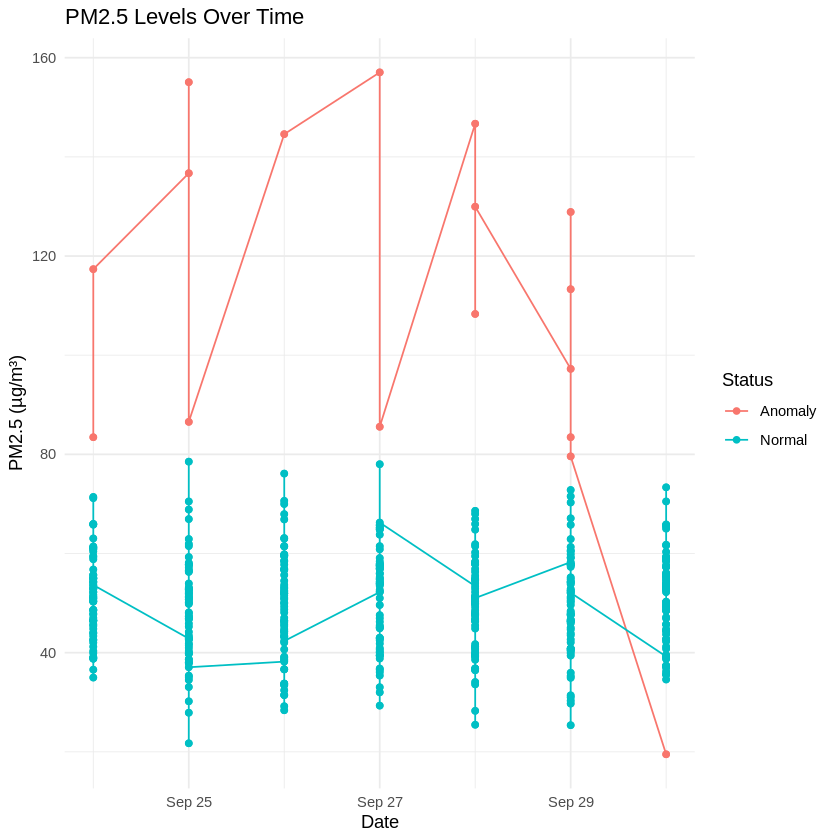

In [ ]:
ggplot(clean_data %>% filter(Pollutant=="PM2.5"),
       aes(x=Timestamp, y=Value, color=Status)) +
  geom_line() + geom_point() +
  labs(title="PM2.5 Levels Over Time", y="PM2.5 (µg/m³)", x="Date") +
  theme_minimal()

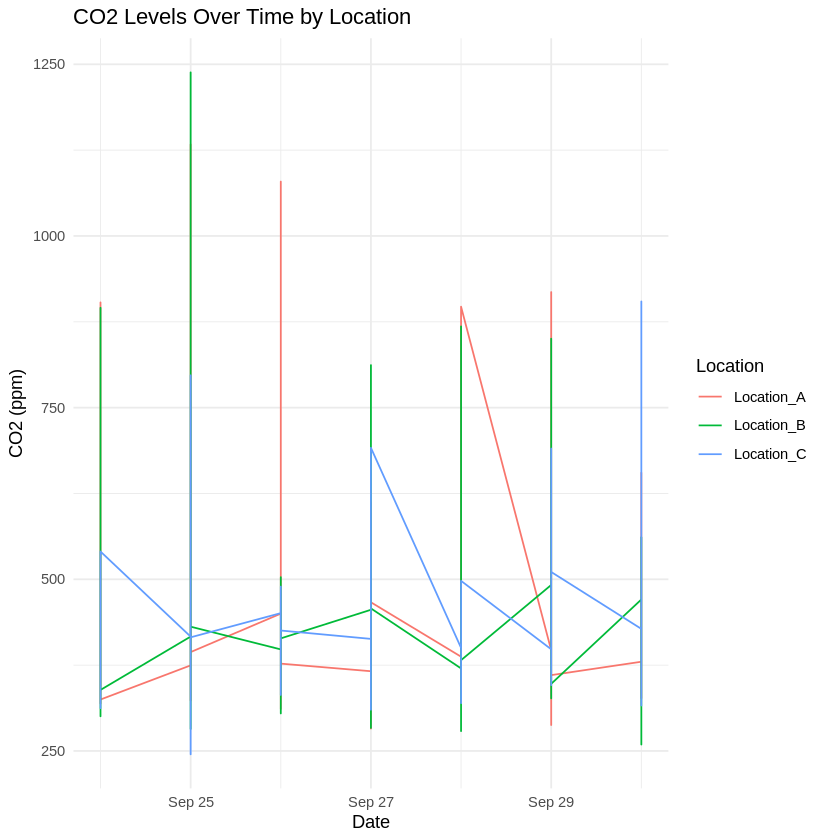

In [ ]:
ggplot(clean_data %>% filter(Pollutant=="CO2"),
       aes(x=Timestamp, y=Value, color=Location)) +
  geom_line() +
  labs(title="CO2 Levels Over Time by Location", y="CO2 (ppm)", x="Date") +
  theme_minimal()

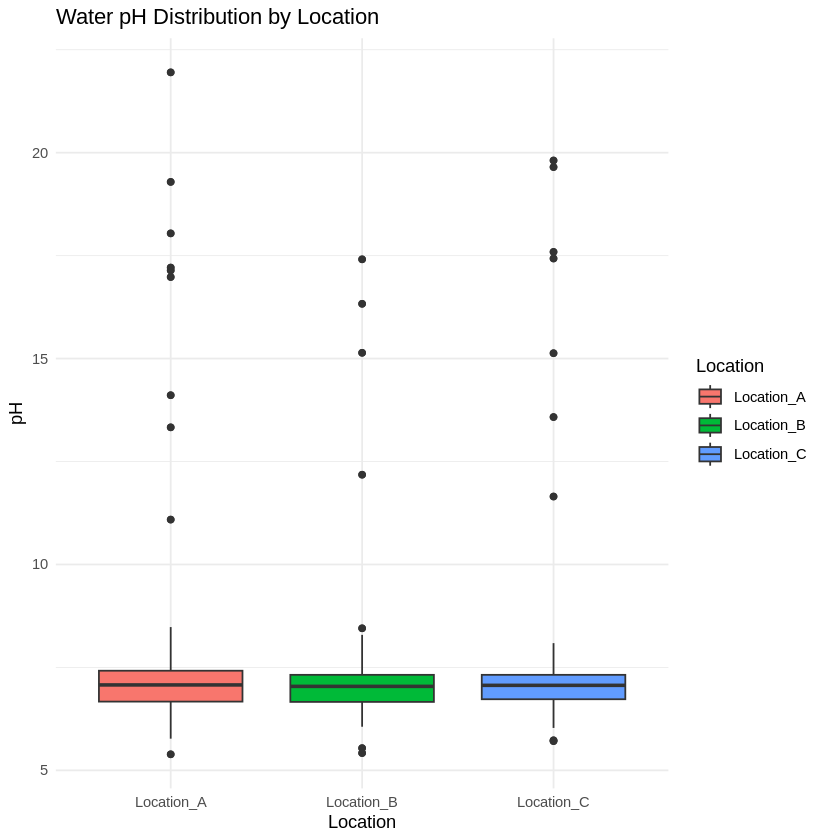

In [ ]:
ggplot(clean_data %>% filter(Pollutant=="pH"),
       aes(x=Location, y=Value, fill=Location)) +
  geom_boxplot() +
  labs(title="Water pH Distribution by Location", y="pH", x="Location") +
  theme_minimal()

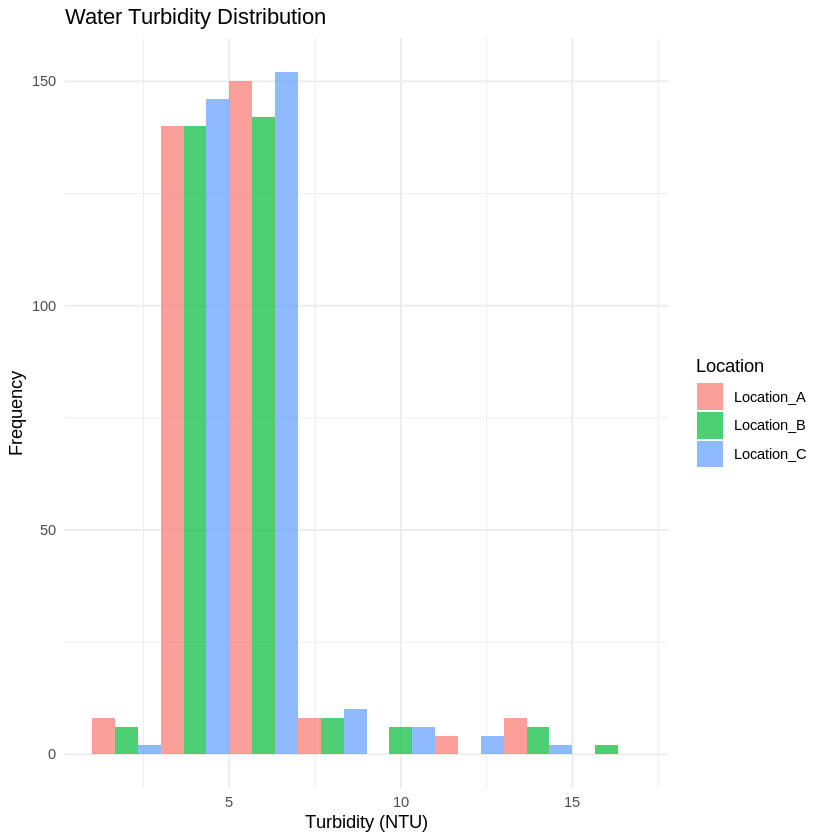

In [ ]:
ggplot(clean_data %>% filter(Pollutant=="Turbidity"),
       aes(x=Value, fill=Location)) +
  geom_histogram(binwidth=2, alpha=0.7, position="dodge") +
  labs(title="Water Turbidity Distribution", y="Frequency", x="Turbidity (NTU)") +
  theme_minimal()

`summarise()` has grouped output by 'Location'. You can override using the
`.groups` argument.
Using Location as id variables



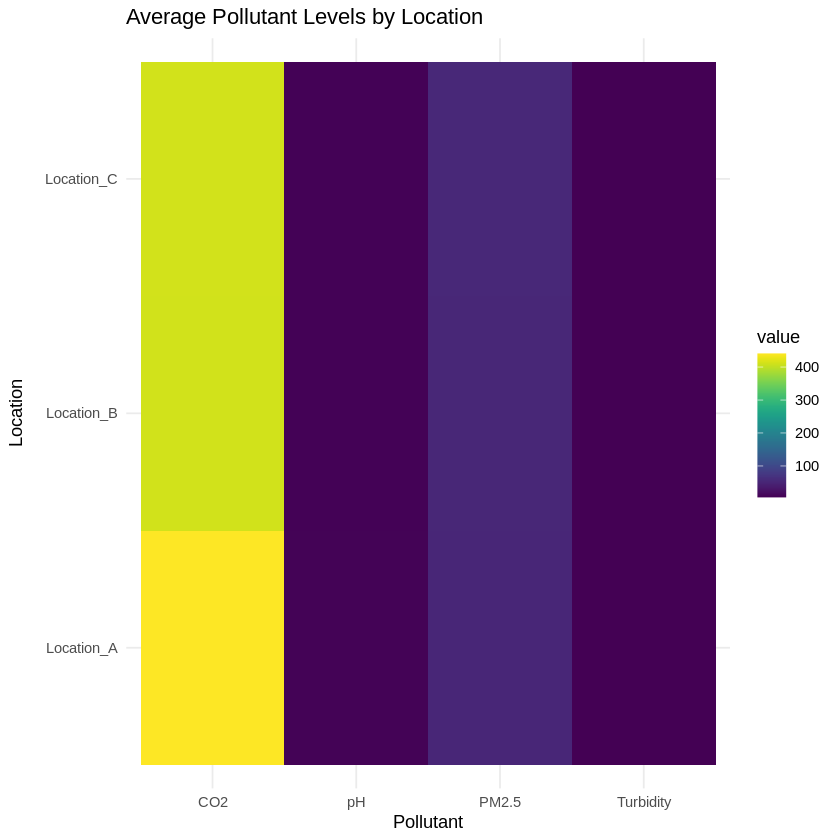

In [ ]:
heatmap_data <- clean_data %>%
  group_by(Location, Pollutant) %>%
  summarise(Average = mean(Value)) %>%
  ungroup() %>%
  dcast(Location ~ Pollutant, value.var = "Average")

ggplot(melt(heatmap_data), aes(x=variable, y=Location, fill=value)) +
  geom_tile() +
  scale_fill_viridis() +
  labs(title="Average Pollutant Levels by Location", x="Pollutant", y="Location") +
  theme_minimal()

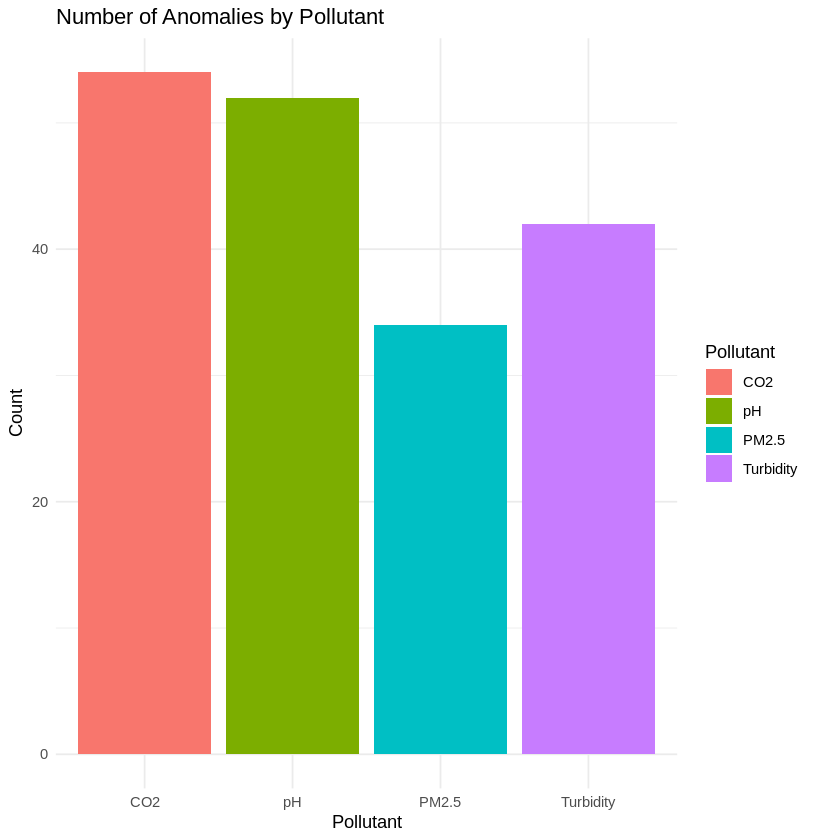

In [ ]:
ggplot(clean_data %>% filter(Status=="Anomaly") %>%
         group_by(Pollutant) %>% summarise(Count = n()),
       aes(x=Pollutant, y=Count, fill=Pollutant)) +
  geom_bar(stat="identity") +
  labs(title="Number of Anomalies by Pollutant", y="Count", x="Pollutant") +
  theme_minimal()

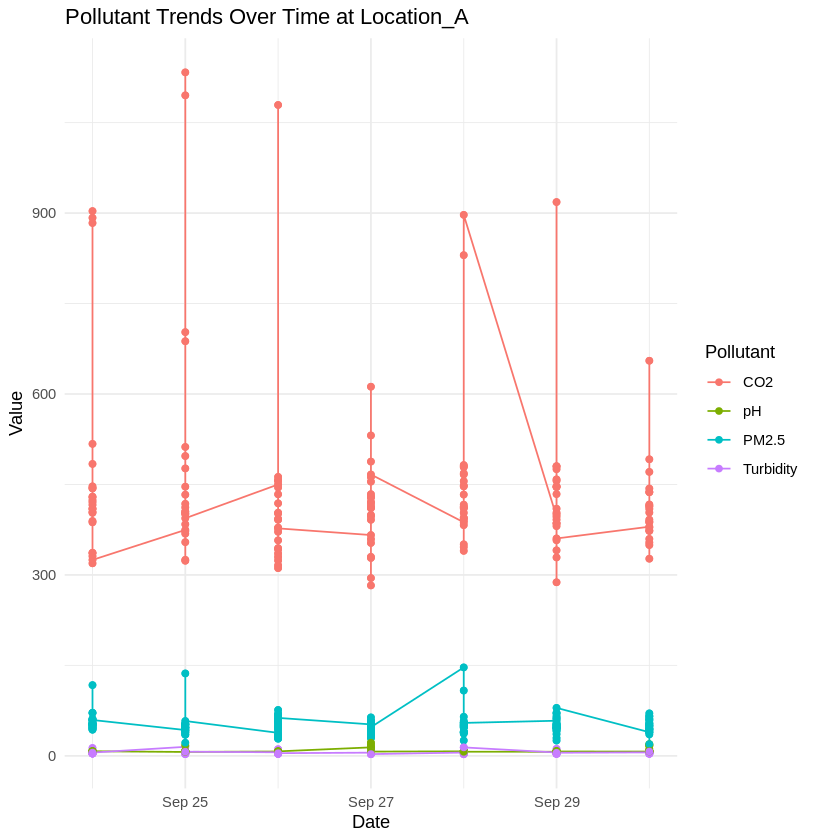

In [ ]:
ggplot(clean_data %>% filter(Location=="Location_A"),
       aes(x=Timestamp, y=Value, color=Pollutant)) +
  geom_line() + geom_point() +
  labs(title="Pollutant Trends Over Time at Location_A", y="Value", x="Date") +
  theme_minimal()

#Export Cleaned Data for Excel

In [92]:
write.csv(clean_data, "sensor_data_cleaned.csv", row.names = FALSE)